# LOADING THE DATA

In [87]:
import numpy as np
import pandas as pd
from google.colab import drive

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, cv

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
import datetime
from sklearn.cluster import KMeans
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 6    

drive.mount('/content/drive/')
sns.set()



Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [88]:
train = pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/train.csv',index_col="tripid")
test  = pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/test.csv',index_col="tripid")
sub =  pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/sample_submission.csv',index_col="tripid")

In [89]:
train

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


In [90]:
test

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47
...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48
222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85
222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79


In [91]:
print(sub.info())
print(train.info())
print(train['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   prediction  8576 non-null   int64
dtypes: int64(1)
memory usage: 134.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16974 non-null  float64
 1   duration                   16974 non-null  float64
 2   meter_waiting              16974 non-null  float64
 3   meter_waiting_fare         16974 non-null  float64
 4   meter_waiting_till_pickup  16974 non-null  float64
 5   pickup_time                17176 non-null  object 
 6   drop_time                  17176 non-null  object 
 7   pick_lat                   17176 non-null  float64
 8   pick_lon                   17176 

In [92]:
cleanup_label = {"label":     {'correct': '1' , 'incorrect': '0'}}
train.replace(cleanup_label, inplace=True)
convert_dict = {'label': 'int64'}
train = train.astype(convert_dict) 
print(train['label'].value_counts())

train

1    15495
0     1681
Name: label, dtype: int64


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1


# Data Preprocessing

## Create Dataset

In [93]:
frames = [train, test]
dataset = pd.concat(frames)
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1.0
189125358,10.5,791.0,47.0,0.00000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1.0
189125719,10.5,1087.0,80.0,0.00000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1.0
189127273,10.5,598.0,271.0,15.66380,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1.0
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48,NaN
222857785,10.5,1378.0,80.0,0.00000,125.0,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85,NaN
222858416,10.5,418.0,56.0,3.28440,93.0,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79,NaN


In [94]:
dataset = dataset.drop_duplicates(keep='first')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25748 entries, 189123628 to 222860703
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            25547 non-null  float64
 1   duration                   25547 non-null  float64
 2   meter_waiting              25547 non-null  float64
 3   meter_waiting_fare         25547 non-null  float64
 4   meter_waiting_till_pickup  25547 non-null  float64
 5   pickup_time                25748 non-null  object 
 6   drop_time                  25748 non-null  object 
 7   pick_lat                   25748 non-null  float64
 8   pick_lon                   25748 non-null  float64
 9   drop_lat                   25748 non-null  float64
 10  drop_lon                   25748 non-null  float64
 11  fare                       25611 non-null  float64
 12  label                      17172 non-null  float64
dtypes: float64(11), object(2)
memory u

In [95]:
## handle NaN values
#dataset = dataset.fillna(0)
#dataset

##  Handle NaN - removed

In [96]:
dataset[dataset['fare'].isnull()]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189157607,10.5,2956.0,1686.0,97.4508,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,0.0
189164806,10.5,3549.0,2689.0,146.9854,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,0.0
189164831,NaN,NaN,NaN,NaN,NaN,11/1/2019 9:17,11/1/2019 9:25,7.27586,80.6136,7.28810,80.6319,NaN,0.0
190066074,NaN,NaN,NaN,NaN,NaN,11/5/2019 16:49,11/5/2019 17:01,7.48201,80.3580,7.50463,80.3510,NaN,0.0
190111701,NaN,NaN,NaN,NaN,NaN,11/5/2019 21:13,11/5/2019 21:15,7.03357,79.9238,7.03365,79.9238,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213449192,NaN,NaN,NaN,NaN,NaN,1/30/2020 22:52,1/30/2020 23:05,6.88183,79.8577,6.84729,79.8734,NaN,0.0
213510465,NaN,NaN,NaN,NaN,NaN,1/31/2020 10:03,1/31/2020 10:04,6.92600,79.8681,6.92596,79.8679,NaN,0.0
213538831,NaN,NaN,NaN,NaN,NaN,1/31/2020 11:53,1/31/2020 13:09,6.70807,79.9125,6.70815,79.9127,NaN,0.0


In [97]:
dataset.iloc[:,[0,1,2,3,4,11]]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare
tripid,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,270.32
189125358,10.5,791.0,47.0,0.00000,134.0,197.85
189125719,10.5,1087.0,80.0,0.00000,61.0,301.64
189127273,10.5,598.0,271.0,15.66380,68.0,82.30
189128020,NaN,NaN,NaN,NaN,NaN,358.39
...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,388.48
222857785,10.5,1378.0,80.0,0.00000,125.0,379.85
222858416,10.5,418.0,56.0,3.28440,93.0,112.79


In [98]:
#imputer = KNNImputer(n_neighbors=5,weights='uniform')
#dataset.iloc[:,[0,1,2,3,4,11]] = imputer.fit_transform(dataset.iloc[:,[0,1,2,3,4,11]])

In [99]:
dataset['additional_fare'].value_counts()

10.50       22258
5.00         1699
30.50         538
40.50         372
60.50         277
110.50        112
21.00         102
80.50          38
25.00          21
55.00          21
11.00          21
35.00          17
0.00           16
85.50          15
20.50          14
105.00          5
81.00           4
75.00           3
210.50          2
80.00           2
221.00          2
450.82          1
111.00          1
70.50           1
91.50           1
160.50          1
10.00           1
12795.03        1
61.00           1
Name: additional_fare, dtype: int64

In [100]:
dataset.isna().sum()

additional_fare               201
duration                      201
meter_waiting                 201
meter_waiting_fare            201
meter_waiting_till_pickup     201
pickup_time                     0
drop_time                       0
pick_lat                        0
pick_lon                        0
drop_lat                        0
drop_lon                        0
fare                          137
label                        8576
dtype: int64

In [101]:
dataset['additional_fare'].value_counts()

10.50       22258
5.00         1699
30.50         538
40.50         372
60.50         277
110.50        112
21.00         102
80.50          38
25.00          21
55.00          21
11.00          21
35.00          17
0.00           16
85.50          15
20.50          14
105.00          5
81.00           4
75.00           3
210.50          2
80.00           2
221.00          2
450.82          1
111.00          1
70.50           1
91.50           1
160.50          1
10.00           1
12795.03        1
61.00           1
Name: additional_fare, dtype: int64

# Feature Engineering

## Calculate Distance

In [102]:
#train_distance_dict = {}

#for ind in dataset.index:
 # pickup_lat = dataset['pick_lat'][ind]
  #pickup_long = dataset['pick_lon'][ind]
  #drop_lat = dataset['drop_lat'][ind]
  #drop_long = dataset['drop_lon'][ind]
  #coords_1 = (pickup_lat, pickup_long)
  #coords_2 = (drop_lat, drop_long)
  #distance = geopy.distance.vincenty(coords_1, coords_2).km
  #train_distance_dict[ind] = distance

#dataset['distance_val'] = dataset.index.to_series().map(train_distance_dict)

In [103]:
import numpy as np # linear algebra
import math as math_stl

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371  # km
    dlat = math_stl.radians(lat2 - lat1)
    dlon = math_stl.radians(lon2 - lon1)
    a = math_stl.sin(dlat / 2) * math_stl.sin(dlat / 2) + math_stl.cos(math_stl.radians(lat1)) * math_stl.cos(math_stl.radians(lat2)) * math_stl.sin(dlon / 2) * math_stl.sin(dlon / 2)
    c = 2 * math_stl.atan2(math_stl.sqrt(a), math_stl.sqrt(1 - a))
    d = radius * c
    return d

In [104]:
dataset['distance'] = 0.0
#test_data['distance'] = 0.0

for index, row in dataset.iterrows():
    dataset.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])

#for index, row in test_data.iterrows():
    #dataset.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])
    
dataset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance
tripid,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782


## Date and Time

In [105]:
pickup_date_time = dataset[["pickup_time"]]
print("pickup_date_time.shape", pickup_date_time.shape)


pickup_date_time.shape (25748, 1)


In [106]:
drop_date_time = dataset[["drop_time"]]
print("drop_date_time.shape", drop_date_time.shape)


drop_date_time.shape (25748, 1)


In [107]:
dataset['pickup_time'] = dataset['pickup_time'].astype('datetime64[ns]')
dataset['drop_time'] = dataset['drop_time'].astype('datetime64[ns]')


dataset['year'] = dataset.pickup_time.dt.year

dataset['month'] = dataset.pickup_time.dt.month

dataset['day'] =dataset.pickup_time.dt.day

dataset['pickup_hour'] = dataset.pickup_time.dt.hour

dataset['pickup_min'] = dataset.pickup_time.dt.minute

dataset['drop_hour'] = dataset.drop_time.dt.hour

dataset['drop_min'] = dataset.drop_time.dt.minute

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [108]:
# Monday is 0 and Sunday is 6.
date_name_dict = {}
for ind in dataset.index:
  year =  dataset['year'][ind].astype(np.int64)
  month =  dataset['month'][ind].astype(np.int64)
  day =  dataset['day'][ind].astype(np.int64)
  date_obj = datetime.date(year,month,day)
  date_Day  = date_obj.weekday()
  date_name_dict[ind] = date_Day

In [109]:
dataset['weekday'] = dataset.index.to_series().map(date_name_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
dataset['weekday'].value_counts()

4    3959
3    3862
5    3792
2    3742
1    3680
0    3675
6    3038
Name: weekday, dtype: int64

## location clustering using KMean(elbow curve)

### pickup clustering

In [111]:
pickup_location = dataset[['pick_lat','pick_lon']]   #pick_lat	pick_lon
drop_location = dataset[['drop_lat','drop_lon']]  #drop_lat	drop_lon
pickup_location

,pick_lat,pick_lon
tripid,,
189123628,6.86252,79.8993
189125358,6.88589,79.8984
189125719,6.90839,79.8651
189127273,6.92570,79.8895
189128020,6.87441,79.8615
...,...,...
222856243,6.85103,79.9567
222857785,6.91293,79.9656
222858416,6.85718,79.9081


In [112]:
dataset.columns[7:9]

Index(['pick_lat', 'pick_lon'], dtype='object')

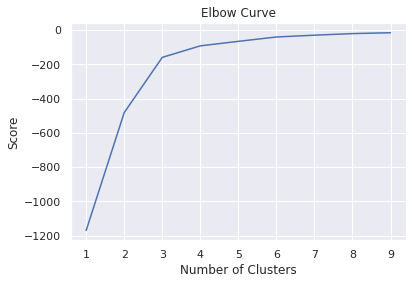

In [113]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dataset[['pick_lat']]
X_axis = dataset[['pick_lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
#When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [114]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(pickup_location[pickup_location.columns[0:2]]) # Compute k-means clustering.
dataset['pick_location_cluster'] = kmeans.fit_predict(pickup_location[pickup_location.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(pickup_location[pickup_location.columns[0:2]]) # Labels of each point
print(dataset['pick_location_cluster'].value_counts())
dataset

0    21742
1     3554
2      452
Name: pick_location_cluster, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster
tripid,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,2019,11,1,0,20,0,34,4,0
189125358,10.5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,2019,11,1,0,56,1,9,4,0
189125719,10.5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,2019,11,1,1,8,1,26,4,0
189127273,10.5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,2019,11,1,2,27,2,37,4,0
189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,2019,11,1,3,34,3,51,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,2020,3,16,21,28,21,56,0,0
222857785,10.5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,2020,3,16,21,59,22,22,0,0
222858416,10.5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,2020,3,16,22,2,22,9,0,0


### drop clustering

In [115]:
dataset.columns[9:11]

Index(['drop_lat', 'drop_lon'], dtype='object')

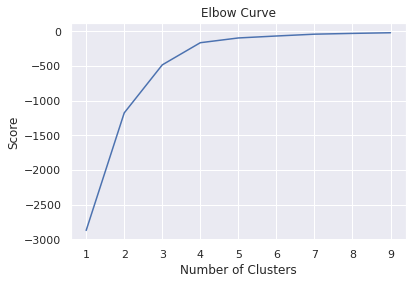

In [116]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dataset[['drop_lat']]
X_axis = dataset[['drop_lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
#When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [117]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(drop_location[drop_location.columns[0:2]]) # Compute k-means clustering.
dataset['drop_location_cluster'] = kmeans.fit_predict(drop_location[drop_location.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(drop_location[drop_location.columns[0:2]]) # Labels of each point
print(dataset['drop_location_cluster'].value_counts())
dataset

0    22191
2     3556
1        1
Name: drop_location_cluster, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster
tripid,,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,2019,11,1,0,20,0,34,4,0,0
189125358,10.5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,2019,11,1,0,56,1,9,4,0,0
189125719,10.5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,2019,11,1,1,8,1,26,4,0,0
189127273,10.5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,2019,11,1,2,27,2,37,4,0,0
189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,2019,11,1,3,34,3,51,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,2020,3,16,21,28,21,56,0,0,0
222857785,10.5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,2020,3,16,21,59,22,22,0,0,0
222858416,10.5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,2020,3,16,22,2,22,9,0,0,0


## New Features

In [118]:
#dataset['add_fare + meter_wait_fare'] = dataset['additional_fare']+dataset['meter_waiting_fare']
#dataset['meter_waiting + meter_waiting_till_pickup'] = dataset['meter_waiting'] + dataset['meter_waiting_till_pickup']
#dataset['duration + meter_waiting_till_pickup + meter_waiting'] = dataset['duration'] + dataset['meter_waiting_till_pickup'] + dataset['meter_waiting']
#dataset['distance_val / fare'] = dataset['distance_val'] / dataset['fare']
#dataset['distance_val / duration'] = dataset['distance_val'] / dataset['duration']
#dataset['additional_fare / distance'] = dataset['additional_fare'] / dataset['distance_val']
#dataset['additional_fare / duration'] = dataset['additional_fare'] / dataset['duration']


In [119]:
dataset.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster'],
      dtype='object')

In [120]:
dataset['(fare - waiting_fare) / distance'] = (dataset['fare']-dataset['meter_waiting_fare']) / dataset['distance']
dataset['additional_fare / distance'] = dataset['additional_fare'] / dataset['distance']
dataset['(fare - waiting_fare) / (duration - meter_waiting)'] = (dataset['fare'] - 
                                                                 dataset['meter_waiting_fare']) / (dataset['duration'] - dataset['meter_waiting'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [121]:
# additional_fare / distance  -done
# (fare - waiting_fare) / distance
# (fare - waiting_fare) / (duration - meter_waiting)

In [122]:

dataset['distance / (duration - meter_waiting)'] = dataset['distance'] / (dataset['duration'] - dataset['meter_waiting'])
dataset['meter_waiting / duration'] = dataset['meter_waiting'] / dataset['duration']


dataset['additional_fare / fare + additional_fare'] = dataset['additional_fare'] / (dataset['fare'] + dataset['additional_fare'])

dataset['(duration-meter_waiting)/fare'] = (dataset['duration'] - dataset['meter_waiting'])/dataset['fare']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [123]:

# distance / (duration - meter_waiting)
# meter_waiting / duration
# additional_fare / fare+additional_fare
# (duration-meter_waiting)/fare

## Categorize Continuous Classes

In [124]:

dataset['additional_fare'].value_counts()

10.50       22258
5.00         1699
30.50         538
40.50         372
60.50         277
110.50        112
21.00         102
80.50          38
25.00          21
55.00          21
11.00          21
35.00          17
0.00           16
85.50          15
20.50          14
105.00          5
81.00           4
75.00           3
210.50          2
80.00           2
221.00          2
450.82          1
111.00          1
70.50           1
91.50           1
160.50          1
10.00           1
12795.03        1
61.00           1
Name: additional_fare, dtype: int64

In [125]:
dataset['additional_fare'] = dataset.additional_fare.astype("category").cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
dataset['additional_fare'].value_counts()

 3     22258
 1      1699
 8       538
 10      372
 12      277
-1       201
 22      112
 6       102
 17       38
 7        21
 4        21
 11       21
 9        17
 0        16
 19       15
 5        14
 21        5
 18        4
 15        3
 25        2
 26        2
 16        2
 23        1
 24        1
 20        1
 27        1
 28        1
 2         1
 13        1
 14        1
Name: additional_fare, dtype: int64

In [127]:
dataset['year'].value_counts()

2020    14399
2019    11349
Name: year, dtype: int64

In [128]:
dataset['year'] = dataset.year.astype("category").cat.codes
dataset['year'].value_counts()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    14399
0    11349
Name: year, dtype: int64

In [129]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25748 entries, 189123628 to 222860703
Data columns (total 31 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   additional_fare                                     25748 non-null  int8          
 1   duration                                            25547 non-null  float64       
 2   meter_waiting                                       25547 non-null  float64       
 3   meter_waiting_fare                                  25547 non-null  float64       
 4   meter_waiting_till_pickup                           25547 non-null  float64       
 5   pickup_time                                         25748 non-null  datetime64[ns]
 6   drop_time                                           25748 non-null  datetime64[ns]
 7   pick_lat                                            25748 non-null  float64       

In [130]:

#Winter - 1 December	28 February
#Spring - 1 March	31 May
#Summer - 1 June	31 August
#Autumn - 1 September	30 November

#peak hours of traffic congestion  -  6a. m to 9.30a.m and 4.30p.m to 7.30p.m
#heavy traffic congestion - afternoon 1.30p.m to 2.30p.m also identify

#weekdays and weekends



In [131]:
#season = ('Winter','Spring','Summer','Autumn')
#Spring - 0
#Summer - 1
#Autumn - 2
#Winter - 3
#season_name_dict = {}
#for ind in dataset.index:
  #month =  dataset['month'][ind].astype(np.int64)
  #if( 2 < dataset['month'][ind] < 6):
    #season_name_dict[ind] = 0
  #elif( 5 < dataset['month'][ind] < 9):
    #season_name_dict[ind] = 1
  #elif( 8 < dataset['month'][ind] < 12):
    #season_name_dict[ind] = 2
  #else:
    #season_name_dict[ind] = 3
    


In [132]:
#dataset['season'] = dataset.index.to_series().map(season_name_dict)

In [133]:
#weekday - 0 , weekend - 1
#in dataset - Monday is 0 and Sunday is 6.
#day_cat = {}
#for ind in dataset.index:
  #day =  dataset['weekday'][ind].astype(np.int64)
  #if(day==5 or day==6):
    #day_cat[ind] = 1
  #else:
    #day_cat[ind] = 0

#dataset['day_category'] = dataset.index.to_series().map(day_cat)



## Normalize

In [134]:
from sklearn.preprocessing import Normalizer




In [135]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


In [136]:
#arr1 = dataset.duration.to_numpy()
#arr2 = dataset.meter_waiting.to_numpy()
#arr3 = dataset.meter_waiting_fare.to_numpy()
#arr3 = dataset.meter_waiting_fare.to_numpy()
#arr4 = dataset.meter_waiting_till_pickup.to_numpy()
#arr5 = dataset.fare.to_numpy()
#arr6 = dataset.distance_val.to_numpy()
#arr = [arr1,arr2,arr3,arr4,arr5,arr6]
#transformer = Normalizer().fit(arr) 
#arr = transformer.transform(arr)

In [137]:
#a = arr[0]
#b = arr[1]
#c = arr[2]
#d = arr[3]
#e = arr[4]
#f = arr[5]
#index=[]
#for ind in dataset.index:
  #index.append(ind) 

#df1 = pd.DataFrame(data=b, index=index, columns=["duration"])
#df2 = pd.DataFrame(data=b, index=index, columns=["meter_waiting"])
#df3 = pd.DataFrame(data=b, index=index, columns=["meter_waiting_fare"])
#df4 = pd.DataFrame(data=b, index=index, columns=["meter_waiting_till_pickup"])
#df5 = pd.DataFrame(data=b, index=index, columns=["fare"])
#df6 = pd.DataFrame(data=b, index=index, columns=["distance_val"])

#dataset['duration'] = df1
#dataset['meter_waiting'] = df2
#dataset['meter_waiting_fare'] = df3
#dataset['meter_waiting_till_pickup'] = df4
#dataset['fare'] = df5
#dataset['distance_val'] = df6

#dataset

# Feature visualization

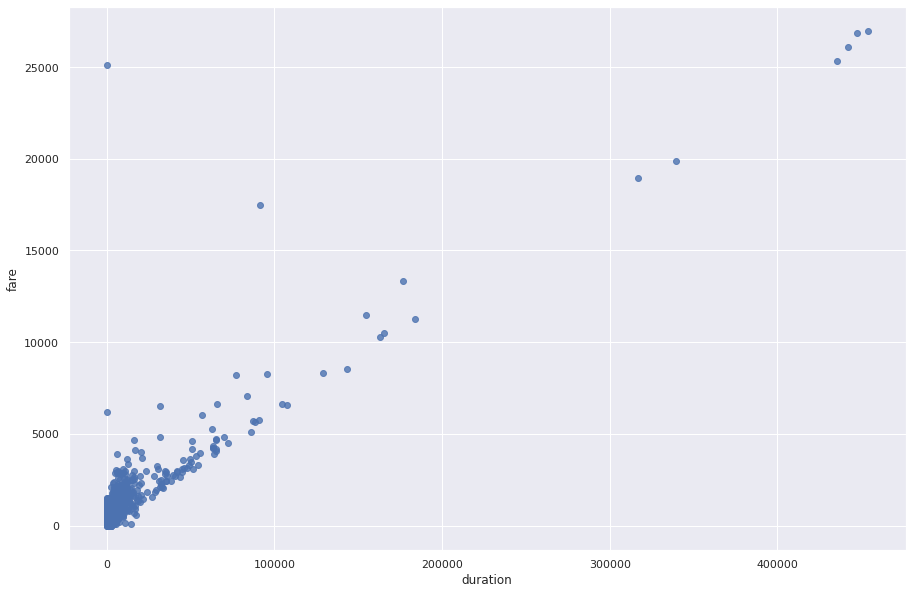

In [138]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.regplot(x="duration",y="fare",fit_reg=False,ci=None,truncate=True,data=dataset)



In [139]:
#dataset['mul_duration'] = dataset.duration * dataset.duration

#fig, ax = plt.subplots()
#fig.set_size_inches(15,10)
#ax = sns.regplot(x="mul_duration",y="fare",fit_reg=False,ci=None,truncate=True,data=dataset)



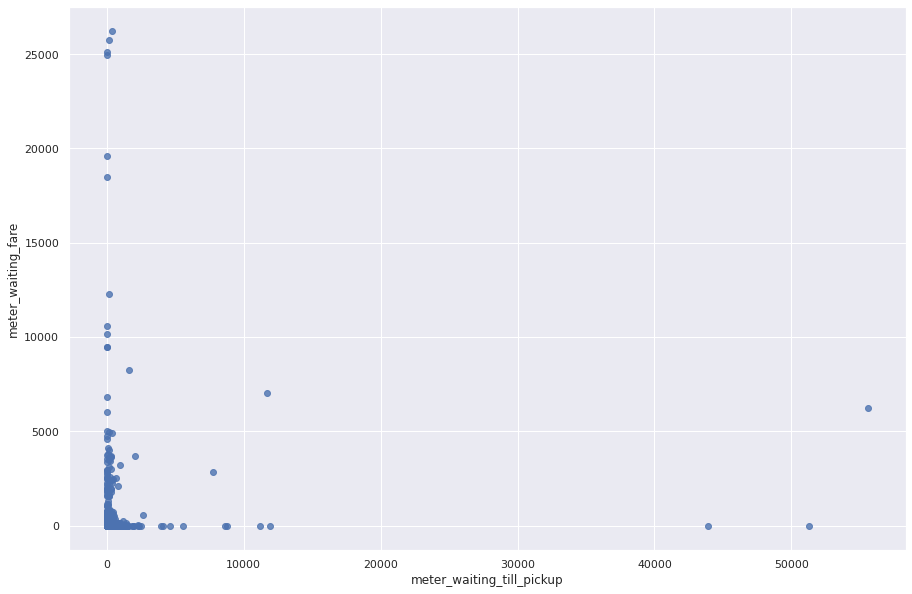

In [140]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.regplot(x="meter_waiting_till_pickup",y="meter_waiting_fare",fit_reg=False,ci=None,truncate=True,data=dataset)


In [141]:
#dataset['mul_meter_waiting'] = dataset.meter_waiting * dataset.meter_waiting
#fig, ax = plt.subplots()
#fig.set_size_inches(15,10)
#ax = sns.regplot(x="meter_waiting_fare",y="mul_meter_waiting",fit_reg=False,ci=None,truncate=True,data=dataset)

In [142]:
#fig = plt.figure(figsize=(6, 6))
#plt.scatter(x="duration",y="actual_fare",
          # linewidths=1, alpha=.7,
         #  edgecolor='k',
         #  s = 200,
          # c='year',data=dataset)
#plt.show()

# Split dataset to train and test

In [143]:
test = dataset.loc[213284604:222860703]
test = test.drop(['label'], axis=1)



In [144]:
train = dataset.loc[189123628:213817296]
convert_dict = {'label': 'int64'}
train = train.astype(convert_dict) 


In [145]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


In [146]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


In [147]:
dataset.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare'],
      dtype='object')

# Setup data to train model

In [148]:
train_features = train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup','pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare']]
print(train_features.info())
train_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 189123628 to 213817296
Data columns (total 28 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   additional_fare                                     17172 non-null  int8   
 1   duration                                            16971 non-null  float64
 2   meter_waiting                                       16971 non-null  float64
 3   meter_waiting_fare                                  16971 non-null  float64
 4   meter_waiting_till_pickup                           16971 non-null  float64
 5   pick_lat                                            17172 non-null  float64
 6   pick_lon                                            17172 non-null  float64
 7   drop_lat                                            17172 non-null  float64
 8   drop_lon                                            17172 non-nu

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,6.87441,79.8615,6.84478,79.9290,358.39,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,3,838.0,93.0,5.4219,451.0,7.29073,80.6367,7.28891,80.6557,198.26,2.105376,1,1,31,22,7,22,21,4,1,2,91.593204,4.987234,0.258843,0.002826,0.110979,0.050297,3.757692
213812756,3,2151.0,428.0,0.0000,39.0,6.90569,79.8516,6.95089,79.9389,581.23,10.868377,1,1,31,23,7,23,43,4,0,0,53.479005,0.966106,0.337336,0.006308,0.198977,0.017745,2.964403
213813930,3,263.0,9.0,0.0000,110.0,7.09210,79.9000,7.10135,79.9017,76.20,1.045518,1,1,31,23,21,23,25,4,0,0,72.882500,10.042864,0.300000,0.004116,0.034221,0.121107,3.333333


In [149]:
train_lable = train[['label']]
print(train_lable.info())
train_lable

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 189123628 to 213817296
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   17172 non-null  int64
dtypes: int64(1)
memory usage: 268.3 KB
None


,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1
...,...
213803193,1
213812756,1
213813930,1


In [150]:
test_features = test[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup','pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare']]

print(test_features.info())
test_features


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 28 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   additional_fare                                     8576 non-null   int8   
 1   duration                                            8576 non-null   float64
 2   meter_waiting                                       8576 non-null   float64
 3   meter_waiting_fare                                  8576 non-null   float64
 4   meter_waiting_till_pickup                           8576 non-null   float64
 5   pick_lat                                            8576 non-null   float64
 6   pick_lon                                            8576 non-null   float64
 7   drop_lat                                            8576 non-null   float64
 8   drop_lon                                            8576 non-null

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
213284604,3,924.0,42.0,2.44860,148.0,6.83454,79.8750,6.77490,79.8840,289.27,6.705702,1,2,1,0,38,0,53,5,0,0,42.772765,1.565832,0.325194,0.007603,0.045455,0.035027,3.049055
213286352,3,4249.0,20.0,0.00000,91.0,6.91168,79.8723,6.55091,79.9706,1912.70,41.558513,1,2,1,1,2,2,13,5,0,0,46.024264,0.252656,0.452282,0.009827,0.004707,0.005460,2.211011
213293973,3,1552.0,255.0,2.65880,23.0,6.92145,79.8478,6.90539,79.8989,394.00,5.916678,1,2,1,5,2,5,28,5,0,0,66.142047,1.774644,0.301728,0.004562,0.164304,0.025958,3.291878
213294622,3,462.0,16.0,0.00000,198.0,6.77433,79.9416,6.80401,79.9407,154.32,3.301761,1,2,1,5,30,5,38,5,0,0,46.738692,3.180121,0.346009,0.007403,0.034632,0.063706,2.890098
213298687,3,814.0,392.0,12.36920,69.0,6.97968,79.9130,6.98875,79.8914,147.47,2.588542,1,2,1,7,0,7,14,5,0,0,52.191855,4.056338,0.320144,0.006134,0.481572,0.066468,2.861599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,6.85103,79.9567,6.85588,79.9214,388.48,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,6.91293,79.9656,6.92112,79.8980,379.85,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,6.85718,79.9081,6.83868,79.9083,112.79,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


# Model

## CAT Boost

In [151]:
convert_dict2 = {'additional_fare': 'int64'}
train_features = train_features.astype(convert_dict2) 
convert_dict2 = {'additional_fare': 'int64'}
test_features = test_features.astype(convert_dict2) 





## Evaluation

In [152]:
rnd_state = 42

# make train val split to try out-of-the-box
X_train, X_val, y_train, y_val = train_test_split(train_features, train_lable, test_size=0.2, random_state=rnd_state)
categorical_features_indices = np.where(train_features.dtypes != np.float)[0]
tree_depths = [6,8]
lrs = [0.03,0.031,0.032,0.03469]

for dep in tree_depths:
  clf = CatBoostClassifier(depth=dep, od_type='Iter', od_wait=20, eval_metric='F1')
  clf.fit(X_train, y_train)
  print(clf.score(X_val, y_val))
#Learning rate set to 0.031537

Learning rate set to 0.031537
0:	learn: 0.9594289	total: 26.6ms	remaining: 26.6s
1:	learn: 0.9608846	total: 46.4ms	remaining: 23.2s
2:	learn: 0.9665445	total: 61.8ms	remaining: 20.5s
3:	learn: 0.9662452	total: 77.2ms	remaining: 19.2s
4:	learn: 0.9667533	total: 91.8ms	remaining: 18.3s
5:	learn: 0.9672532	total: 107ms	remaining: 17.7s
6:	learn: 0.9687290	total: 122ms	remaining: 17.3s
7:	learn: 0.9693300	total: 137ms	remaining: 17s
8:	learn: 0.9705929	total: 152ms	remaining: 16.7s
9:	learn: 0.9709053	total: 167ms	remaining: 16.5s
10:	learn: 0.9710070	total: 181ms	remaining: 16.3s
11:	learn: 0.9711157	total: 198ms	remaining: 16.3s
12:	learn: 0.9712903	total: 214ms	remaining: 16.2s
13:	learn: 0.9714172	total: 229ms	remaining: 16.1s
14:	learn: 0.9724160	total: 244ms	remaining: 16s
15:	learn: 0.9724887	total: 260ms	remaining: 16s
16:	learn: 0.9725745	total: 275ms	remaining: 15.9s
17:	learn: 0.9730373	total: 290ms	remaining: 15.8s
18:	learn: 0.9728466	total: 304ms	remaining: 15.7s
19:	learn: 0

In [153]:
for lr in lrs:
  clf = CatBoostClassifier(learning_rate=lr, depth=6, od_type='Iter', od_wait=20, eval_metric='F1')
  clf.fit(X_train, y_train)
  print(clf.score(X_val, y_val))

0:	learn: 0.9594289	total: 16.1ms	remaining: 16.1s
1:	learn: 0.9608846	total: 30.9ms	remaining: 15.4s
2:	learn: 0.9665445	total: 50.4ms	remaining: 16.7s
3:	learn: 0.9662452	total: 66ms	remaining: 16.4s
4:	learn: 0.9667533	total: 81.8ms	remaining: 16.3s
5:	learn: 0.9672532	total: 98.8ms	remaining: 16.4s
6:	learn: 0.9686907	total: 113ms	remaining: 16s
7:	learn: 0.9692917	total: 128ms	remaining: 15.9s
8:	learn: 0.9705929	total: 143ms	remaining: 15.7s
9:	learn: 0.9708669	total: 172ms	remaining: 17.1s
10:	learn: 0.9710070	total: 187ms	remaining: 16.8s
11:	learn: 0.9710386	total: 202ms	remaining: 16.6s
12:	learn: 0.9712518	total: 222ms	remaining: 16.8s
13:	learn: 0.9714172	total: 236ms	remaining: 16.6s
14:	learn: 0.9721507	total: 253ms	remaining: 16.6s
15:	learn: 0.9724247	total: 268ms	remaining: 16.5s
16:	learn: 0.9723092	total: 282ms	remaining: 16.3s
17:	learn: 0.9728466	total: 299ms	remaining: 16.3s
18:	learn: 0.9726646	total: 314ms	remaining: 16.2s
19:	learn: 0.9731294	total: 328ms	remai

## Feature importance

In [154]:
clf = CatBoostClassifier(learning_rate=0.03469, depth=6, od_type='Iter', od_wait=20, eval_metric='F1')
clf.fit(X_train, y_train)



0:	learn: 0.9594289	total: 15ms	remaining: 15s
1:	learn: 0.9608846	total: 29.8ms	remaining: 14.9s
2:	learn: 0.9665445	total: 44.5ms	remaining: 14.8s
3:	learn: 0.9669350	total: 59.7ms	remaining: 14.9s
4:	learn: 0.9672888	total: 74.7ms	remaining: 14.9s
5:	learn: 0.9678388	total: 89.4ms	remaining: 14.8s
6:	learn: 0.9688935	total: 104ms	remaining: 14.7s
7:	learn: 0.9693874	total: 119ms	remaining: 14.7s
8:	learn: 0.9699972	total: 133ms	remaining: 14.6s
9:	learn: 0.9703316	total: 152ms	remaining: 15s
10:	learn: 0.9706804	total: 167ms	remaining: 15s
11:	learn: 0.9711042	total: 182ms	remaining: 15s
12:	learn: 0.9710363	total: 197ms	remaining: 14.9s
13:	learn: 0.9710409	total: 211ms	remaining: 14.9s
14:	learn: 0.9725360	total: 231ms	remaining: 15.1s
15:	learn: 0.9728358	total: 245ms	remaining: 15.1s
16:	learn: 0.9727630	total: 260ms	remaining: 15s
17:	learn: 0.9728658	total: 274ms	remaining: 15s
18:	learn: 0.9730588	total: 289ms	remaining: 14.9s
19:	learn: 0.9733291	total: 305ms	remaining: 14.9

In [155]:
print(clf.score(X_val, y_val))
print(clf.get_feature_importance())

print(clf.feature_names_)

0.9595342066957787
[ 1.72789603  4.69846543  2.13619     1.96273258  6.86747999  3.14716639
  2.33305814  2.286879    2.37719594  9.23253034  3.90710502  0.88505763
  2.30640477  3.19134659  2.00303285  2.53652136  1.66165378  2.45804889
  1.45661484  0.10208984  0.07923382  7.20158268  2.20443767  8.49996701
  3.61888828  2.64495826  3.2996713  15.17379156]
['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance', 'year', 'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min', 'weekday', 'pick_location_cluster', 'drop_location_cluster', '(fare - waiting_fare) / distance', 'additional_fare / distance', '(fare - waiting_fare) / (duration - meter_waiting)', 'distance / (duration - meter_waiting)', 'meter_waiting / duration', 'additional_fare / fare + additional_fare', '(duration-meter_waiting)/fare']


In [156]:
train_features = train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup','pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare']]

In [157]:
test_features = test[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup','pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare']]

In [158]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_lable, test_size=0.2, random_state=rnd_state)

In [159]:
clf = CatBoostClassifier(learning_rate=0.03469, depth=6, od_type='Iter', od_wait=20, eval_metric='F1')
clf.fit(X_train, y_train)


0:	learn: 0.9635186	total: 15.5ms	remaining: 15.5s
1:	learn: 0.9633146	total: 30.3ms	remaining: 15.1s
2:	learn: 0.9669620	total: 44.8ms	remaining: 14.9s
3:	learn: 0.9701717	total: 59.7ms	remaining: 14.9s
4:	learn: 0.9698528	total: 73.7ms	remaining: 14.7s
5:	learn: 0.9692563	total: 88.8ms	remaining: 14.7s
6:	learn: 0.9716053	total: 106ms	remaining: 15.1s
7:	learn: 0.9715033	total: 120ms	remaining: 14.9s
8:	learn: 0.9714218	total: 135ms	remaining: 14.9s
9:	learn: 0.9714172	total: 149ms	remaining: 14.8s
10:	learn: 0.9712156	total: 164ms	remaining: 14.7s
11:	learn: 0.9713651	total: 178ms	remaining: 14.7s
12:	learn: 0.9713991	total: 193ms	remaining: 14.7s
13:	learn: 0.9715260	total: 208ms	remaining: 14.6s
14:	learn: 0.9717707	total: 225ms	remaining: 14.8s
15:	learn: 0.9720041	total: 240ms	remaining: 14.8s
16:	learn: 0.9728466	total: 255ms	remaining: 14.7s
17:	learn: 0.9726494	total: 270ms	remaining: 14.7s
18:	learn: 0.9728037	total: 284ms	remaining: 14.7s
19:	learn: 0.9731166	total: 299ms	r

In [160]:
print(clf.score(X_val, y_val))
print(clf.get_feature_importance())

print(clf.feature_names_)

0.9589519650655022
[ 2.20619584  4.07500389  2.20860544  2.37534451  6.70442602  2.61573719
  2.25266512  2.32864439  2.37972209  8.58486786  3.53180881  3.13694547
  3.23097494  2.04412273  2.40809312  1.58054561  2.64428095  1.39589478
  7.66135734  2.39669975  8.13940843  3.89690355  2.67589907  3.48855226
 16.03730086]
['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance', 'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min', 'weekday', '(fare - waiting_fare) / distance', 'additional_fare / distance', '(fare - waiting_fare) / (duration - meter_waiting)', 'distance / (duration - meter_waiting)', 'meter_waiting / duration', 'additional_fare / fare + additional_fare', '(duration-meter_waiting)/fare']


## Ensembling and prediction

In [161]:
clf_od1 = CatBoostClassifier(learning_rate=0.03469,depth=6,od_type='Iter', od_wait=20, eval_metric='F1')
clf_od1.fit(train_features, train_lable)


prediction1 = clf_od1.predict(test_features).astype('int')

0:	learn: 0.9650549	total: 17.3ms	remaining: 17.3s
1:	learn: 0.9679617	total: 33.8ms	remaining: 16.9s
2:	learn: 0.9689790	total: 50.3ms	remaining: 16.7s
3:	learn: 0.9706414	total: 66.1ms	remaining: 16.5s
4:	learn: 0.9704333	total: 82.2ms	remaining: 16.4s
5:	learn: 0.9692813	total: 98.8ms	remaining: 16.4s
6:	learn: 0.9713706	total: 115ms	remaining: 16.3s
7:	learn: 0.9705892	total: 132ms	remaining: 16.3s
8:	learn: 0.9713181	total: 148ms	remaining: 16.3s
9:	learn: 0.9712928	total: 164ms	remaining: 16.2s
10:	learn: 0.9714449	total: 180ms	remaining: 16.2s
11:	learn: 0.9714431	total: 196ms	remaining: 16.2s
12:	learn: 0.9714376	total: 212ms	remaining: 16.1s
13:	learn: 0.9717801	total: 232ms	remaining: 16.3s
14:	learn: 0.9718631	total: 249ms	remaining: 16.3s
15:	learn: 0.9721113	total: 265ms	remaining: 16.3s
16:	learn: 0.9723957	total: 280ms	remaining: 16.2s
17:	learn: 0.9724503	total: 297ms	remaining: 16.2s
18:	learn: 0.9729661	total: 313ms	remaining: 16.1s
19:	learn: 0.9729593	total: 328ms	r

In [162]:
clf_od2 = CatBoostClassifier(learning_rate=0.0330,depth=6,od_type='Iter', od_wait=20, eval_metric='F1')
clf_od2.fit(train_features, train_lable)


prediction2 = clf_od2.predict(test_features).astype('int')

0:	learn: 0.9650549	total: 24.4ms	remaining: 24.3s
1:	learn: 0.9679617	total: 41.8ms	remaining: 20.9s
2:	learn: 0.9689790	total: 58.8ms	remaining: 19.6s
3:	learn: 0.9706414	total: 75.8ms	remaining: 18.9s
4:	learn: 0.9704333	total: 92.4ms	remaining: 18.4s
5:	learn: 0.9692813	total: 110ms	remaining: 18.2s
6:	learn: 0.9713706	total: 126ms	remaining: 17.9s
7:	learn: 0.9705603	total: 142ms	remaining: 17.6s
8:	learn: 0.9713181	total: 159ms	remaining: 17.5s
9:	learn: 0.9713254	total: 174ms	remaining: 17.3s
10:	learn: 0.9714449	total: 190ms	remaining: 17.1s
11:	learn: 0.9714123	total: 207ms	remaining: 17s
12:	learn: 0.9714376	total: 227ms	remaining: 17.2s
13:	learn: 0.9718399	total: 244ms	remaining: 17.2s
14:	learn: 0.9716841	total: 260ms	remaining: 17.1s
15:	learn: 0.9719288	total: 276ms	remaining: 17s
16:	learn: 0.9719235	total: 292ms	remaining: 16.9s
17:	learn: 0.9727022	total: 309ms	remaining: 16.9s
18:	learn: 0.9729250	total: 334ms	remaining: 17.3s
19:	learn: 0.9728221	total: 350ms	remain

In [163]:
clf_od3 = CatBoostClassifier(learning_rate=0.03500,depth=6,od_type='Iter', od_wait=20, eval_metric='F1')
clf_od3.fit(train_features, train_lable)


prediction3 = clf_od3.predict(test_features).astype('int')

0:	learn: 0.9650549	total: 20.4ms	remaining: 20.3s
1:	learn: 0.9679617	total: 36.8ms	remaining: 18.3s
2:	learn: 0.9689790	total: 52.9ms	remaining: 17.6s
3:	learn: 0.9706414	total: 68.8ms	remaining: 17.1s
4:	learn: 0.9704333	total: 84.6ms	remaining: 16.8s
5:	learn: 0.9692813	total: 101ms	remaining: 16.8s
6:	learn: 0.9713706	total: 120ms	remaining: 17s
7:	learn: 0.9705892	total: 136ms	remaining: 16.9s
8:	learn: 0.9713181	total: 152ms	remaining: 16.8s
9:	learn: 0.9712928	total: 169ms	remaining: 16.7s
10:	learn: 0.9714449	total: 184ms	remaining: 16.6s
11:	learn: 0.9714431	total: 201ms	remaining: 16.5s
12:	learn: 0.9714376	total: 217ms	remaining: 16.5s
13:	learn: 0.9717801	total: 236ms	remaining: 16.6s
14:	learn: 0.9718631	total: 253ms	remaining: 16.6s
15:	learn: 0.9720787	total: 278ms	remaining: 17.1s
16:	learn: 0.9724573	total: 294ms	remaining: 17s
17:	learn: 0.9724503	total: 310ms	remaining: 16.9s
18:	learn: 0.9730312	total: 328ms	remaining: 16.9s
19:	learn: 0.9729918	total: 344ms	remain

In [164]:
avg_pred = (prediction1+prediction2+prediction3) / 3

In [165]:
avg_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [166]:
index=[]
for ind in test_features.index:
  index.append(ind)

test_features['tripid'] = index

submission = pd.DataFrame({
        "tripid": test_features["tripid"],
        "prediction": avg_pred
    })
submission = submission.drop(['tripid'],1)
test_features = test_features.drop(['tripid'],1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [167]:
submission.loc[(submission['prediction'] > 0.5 ) , 'prediction'] = 1
submission.loc[(submission['prediction'] <= 0.5 ) , 'prediction'] = 0

In [168]:
submission['prediction'] =submission['prediction'].astype(np.float16)
submission['prediction'] =submission['prediction'].astype(int)
print(submission['prediction'].value_counts())
submission

1    8150
0     426
Name: prediction, dtype: int64


,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
...,...
222856243,1
222857785,1
222858416,1


In [ ]:
DATA_PATH = '/content/drive/My Drive/Data Sets/ML data/output'
sub_path = DATA_PATH + 'final_ensembling.csv'
submission.to_csv(sub_path, index=True)
print('Completed!')

Completed!


## Train and Predict(with out ensembling)

In [ ]:
# Submission 1: catboost submission with all training data and early stopping on Accuracy

clf_od = CatBoostClassifier(learning_rate=0.03469,depth=6)
clf_od.fit(train_features, train_lable)


prediction = clf_od.predict(test_features).astype('int')

0:	learn: 0.6437020	total: 16.7ms	remaining: 16.7s
1:	learn: 0.6014437	total: 33.8ms	remaining: 16.8s
2:	learn: 0.5600339	total: 50.2ms	remaining: 16.7s
3:	learn: 0.5213302	total: 66.7ms	remaining: 16.6s
4:	learn: 0.4882367	total: 83.9ms	remaining: 16.7s
5:	learn: 0.4590226	total: 104ms	remaining: 17.2s
6:	learn: 0.4296559	total: 120ms	remaining: 17s
7:	learn: 0.4055943	total: 139ms	remaining: 17.3s
8:	learn: 0.3815637	total: 156ms	remaining: 17.2s
9:	learn: 0.3592012	total: 172ms	remaining: 17.1s
10:	learn: 0.3412820	total: 189ms	remaining: 17s
11:	learn: 0.3235217	total: 206ms	remaining: 16.9s
12:	learn: 0.3102635	total: 224ms	remaining: 17s
13:	learn: 0.2966448	total: 241ms	remaining: 17s
14:	learn: 0.2850746	total: 257ms	remaining: 16.9s
15:	learn: 0.2753502	total: 274ms	remaining: 16.8s
16:	learn: 0.2655914	total: 290ms	remaining: 16.8s
17:	learn: 0.2554667	total: 306ms	remaining: 16.7s
18:	learn: 0.2461707	total: 322ms	remaining: 16.6s
19:	learn: 0.2388792	total: 338ms	remaining:

In [ ]:

index=[]
for ind in test_features.index:
  index.append(ind)

test_features['tripid'] = index

submission = pd.DataFrame({
        "tripid": test_features["tripid"],
        "prediction": prediction
    })
submission = submission.drop(['tripid'],1)
test_features = test_features.drop(['tripid'],1)
print(submission['prediction'].value_counts())
submission

1    8149
0     427
Name: prediction, dtype: int64


,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
...,...
222856243,1
222857785,1
222858416,1


In [ ]:
DATA_PATH = '/content/drive/My Drive/Data Sets/ML data/output'
sub_path = DATA_PATH + 'day_before_last_cat_new_features.csv'
submission.to_csv(sub_path, index=True)
print('Completed!')

Completed!
